# Tutorial Complexity Cuantifier

This tutorial shows how to use DimCuantifier, this method use principal component analysis to calculate how many dimensions are needed to represent a certain amount of variance and use that as a measure of complexity of the text. Using the number of dimensions needed as an estimate of complexity can be used to compare different texts and will be called complexity of the text in this notebook. 

This analisis can be performed using word embeddings or polar embeddings, which are interpretable representations of words. Also, Complexity can be calculated for a document or for a corpus

In [41]:
# Import 
from DimCuantifier import DimCuantifier
from PreProcessingDimCuantifier import PreProcessingDimCuantifier

import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
import numpy as np
import matplotlib.pyplot as plt

## Preprocessing

Use PreProcessingDimCuantifier to normalize Glove pretrained word embeddings and to collect a list of polar words to use to create polar embeddings

In [2]:
PreProcess = PreProcessingDimCuantifier()

In [4]:
# Normalized GloVe embeddings

norm_glove_42B = 'normalized_glove.42B.300d.mod'

model_glove = gensim.models.KeyedVectors.load_word2vec_format("glove.42B.300d.txt", binary=False, no_header=True)

PreProcess.generate_normalized_embeddings(model_glove, norm_glove_42B)

In [5]:
# Load normalized word embeddings
current_model = gensim.models.KeyedVectors.load_word2vec_format(norm_glove_42B, binary=True)

### Set Polar Words Pairs List

In this section polar words pairs are loaded and then format them into a list of tuples.

Functions from PreProcessingDimCuantifier used below are specific to extract polar pairs from attached files, but it can be done differently as long as the final list is composed of tuples, and tuples are the polar pairs in string format. The lists of antonyms used here are obtained from [Polar framework repository](https://github.com/Sandipan99/POLAR)

In [6]:
filenames_list = ['.\Antonym_sets\LenciBenotto.val',
                  '.\Antonym_sets\LenciBenotto.test',
                  '.\Antonym_sets\EVALution.val',
                  '.\Antonym_sets\EVALution.test']

# Extract polar pairs from files 
list_polar_pairs = PreProcess.list_polar_words_tuple(filenames_list, current_model)

# Print a sample of polar pairs
print(list_polar_pairs[0:5])

[('implicate', 'exclude'), ('assertion', 'rejection'), ('terminal', 'beginning'), ('lop', 'secure'), ('pastor', 'libertine')]


Just as in Polar framework, function select_polar_words_list is used to select pair of words in order for words are not dupicated, and for that, the pair with the most different cosine similarity is keeped if a word repeats in different pairs

In [7]:
# Select most different polar pairs when there is repetition of words
final_polar_pairs_list = PreProcess.select_polar_words_list(current_model, list_polar_pairs)

# Print a sample of final polar pairs
print(final_polar_pairs_list[0:5])

[('exclude', 'inscribe'), ('assertion', 'meek'), ('beginning', 'terminal'), ('lop', 'secure'), ('libertine', 'pastor')]


## Create DimCuantifier Object

Now that the word embeddings model and the polar words pairs are set, it can be initialized a DimCuantifier object that calculates the complexity of a text

In [79]:
# Initialize DimCuantifier object

DC = DimCuantifier(current_model, final_polar_pairs_list)

In [80]:
# Show how many polar pairs were given to DimCuantifier

print(f'There is {DC.get_n_polar_pairs()} polar pairs')

There is 1468 polar pairs


## Set Corpus

Now it is needed to set a corpus to calculate complexity to. The format needed is a list of lists, with tokenized words. In PreProcessingDimCuantifier there is a function that helps tokenize strings, remove stopwords and words that do not appear in the word embeddings model, but for this tutorial it will be used a small toy example

In [81]:
toy_example = [
    'i like red candy', 
    'i like green candy', 
    'candy is good and red is the best',
    'candy is bad for you',
]

# Tokenize toy example
for i, document in enumerate(toy_example):
    toy_example[i] = document.split()

In [82]:
# Set Corpus to DimCuantifier
DC.set_corpus(toy_example)

# Show corpus set
print('Corpus Set:')
print(DC.get_corpus(), end='\n\n')

# Show word frequency of the set corpus
print('Word frequency dictionary of the set corpus:')
for value, count in DC.get_word_frequency_dictionary().items():
    print(value, count)

Corpus Set:
[['i', 'like', 'red', 'candy'], ['i', 'like', 'green', 'candy'], ['candy', 'is', 'good', 'and', 'red', 'is', 'the', 'best'], ['candy', 'is', 'bad', 'for', 'you']]

Word frequency dictionary of the set corpus:
i 2
like 2
red 2
candy 4
green 1
is 3
good 1
and 1
the 1
best 1
bad 1
for 1
you 1


# Cuantify Complexity

Now that the corpus is set it is possible to obtain the corpus complexity and each document complexity. 

First, it is necessary to generates polar embeddings for words and documents (embeddings vector for documents are calculated as the average of the embeddings vector in the document). Then it is possible to calculate complexity for documents (analyzing variation of the words in the document) and for corpus (analyzing variation of the documents in the corpus).

This is made by performing Principal Component Analysis (dimensions reduction algorithm) to the polar embeddings, this way the algorithm generates dimensions called Principal Components that represents certain amount of variance of the original dimensions. By default DimCuantifier selects the first dimensions needed to accumulate 99% of the original variation, but this can be set to another amount

## Corpus level analysis

In [83]:
# Get the number of dimensions of the corpus using polar embeddings
n_dimensions_PE = DC.cuantify_dim(on='corpus', embedding='polar')
print(f'The corpus has a estimated complexity of: {n_dimensions_PE} dimensions when using Polar embeddings')

n_dimensions_WE = DC.cuantify_dim(on='corpus', embedding='word')
print(f'The corpus has a estimated complexity of: {n_dimensions_WE} dimensions when using Word embeddings')

The corpus has a estimated complexity of: 3 dimensions when using Polar embeddings
The corpus has a estimated complexity of: 3 dimensions when using Word embeddings


The function scree_plot_corpus show a scree plot of the corpus.

This shows every principal component needed to reach the set amount of variance (99% for default) and the contribution of each component

In [84]:
def scree_plot_corpus(dimcuantifier, title=None):
    """ Plot percentage of variance represented for each principal component at corpus level

    Args:
        dimcuantifier (DimCuantifier): Object of DimCuantifier class
        title (str, optional): Plot title. Defaults to None.
    """

    if dimcuantifier.pca_corpus == None:
            print('First call cuantify_dim to perform PCA on corpus')
            return

    # Collect the percentage of variance explained by each principal component
    percentage_var = np.round(dimcuantifier.pca_corpus.explained_variance_ratio_* 100, decimals=1)
    labels = ['PC' + str(i+1) for i,_ in enumerate(percentage_var)]
    
    # Plot the percentage of variance in a bar chart
    plt.bar(x=range(0, len(percentage_var)), height=percentage_var, tick_label=labels)
    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    title = title if title else 'Scree Plot Corpus'
    plt.title(title)

    # Plot the cumulative variance explained by the principal components
    plt.axis([-1, len(dimcuantifier.pca_corpus.explained_variance_ratio_), 0, 100.5])
    plt.yticks(np.arange(0, 101, step=10))
    plt.xticks(rotation=90)
    var=np.cumsum(np.round(dimcuantifier.pca_corpus.explained_variance_ratio_, decimals=3)*100)
    plt.plot(var, color='black', marker='*')
    plt.grid()

    plt.show()

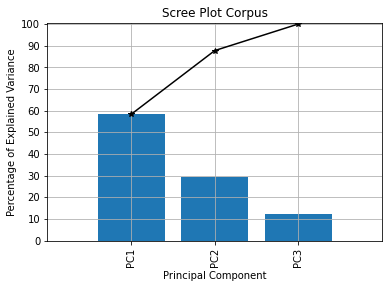

In [85]:
scree_plot_corpus(DC)

The function calculate_loading_scores_corpus calculates loading scores for all principal components of the corpus and print the first five polar dimensions (or the amount of dimensions estimated for the corpus if that numbers is bigger than five) for each principal component that appear in the scree plot.

It can be obtained all the loading scores in a pandas dataframe with the function get_loading_scores_corpus (but calculate_loading_scores_corpus has to be called first)

Before sorting and printing in calculate_loading_scores(on='corpus'), the absolute values of the loading scores are taken; but they are not taken when get_loading_scores_corpus is called.

In [86]:
DC.calculate_loading_scores(on='corpus')
DC.get_loading_scores(on='corpus').sort_values(by='PC_1', ascending=False).head()

,PC_1,PC_2,PC_3,weighted_sum,sum
"(can, jar)",0.034183,-0.000594,-0.000684,0.020182,0.055644
"(accept, appall)",0.034181,-0.000027,0.001358,0.020097,0.055663
"(actual, symbolic)",0.034178,-0.001085,0.000323,0.020280,0.055866
"(acceptable, unsatisfactory)",0.034172,0.000204,-0.002196,0.020246,0.056818
"(guide, swat)",0.034162,0.000550,0.002707,0.020405,0.057825


## Documents level analysis

Obtain complexity estimated for documents, in this case cuantify_dim(on='documents') returns a list with dimensions estimated for each document

In [87]:
# Print dimensions estimated for each document polar embeddings

for i, dim in enumerate(DC.cuantify_dim(on='documents', embedding='polar')):
    print(f'Document {i+1} has a complexity of {dim} dimensions using polar embeddings')

Document 1 has a complexity of 3 dimensions using polar embeddings
Document 2 has a complexity of 3 dimensions using polar embeddings
Document 3 has a complexity of 6 dimensions using polar embeddings
Document 4 has a complexity of 4 dimensions using polar embeddings


The same can be done with word embeddings but in a small example there is not much difference

In [88]:
# Print dimensions estimated for each document word embeddings

for i, dim in enumerate(DC.cuantify_dim(on='documents', embedding='word')):
    print(f'Document {i+1} has a complexity of {dim} dimensions using word embeddings')


Document 1 has a complexity of 3 dimensions using word embeddings
Document 2 has a complexity of 3 dimensions using word embeddings
Document 3 has a complexity of 6 dimensions using word embeddings
Document 4 has a complexity of 4 dimensions using word embeddings


The function scree_plot_documents makes a scree plot for every document

In [89]:
def scree_plot_documents(dimcuantifier):
    """ Plot percentage of variance represented for each principal component at document level

    Args:
        dimcuantifier (DimCuantifier): Object of DimCuantifier class
    """    

    if dimcuantifier.pca_documents_list == []:
        print('First call cuantify_dim to perform PCA on documents')
        return

    # Plot the percentage of variance in a bar chart for each document
    for i, pca in enumerate(dimcuantifier.pca_documents_list):

        percentage_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
        labels = ['PC' + str(i+1) for i,_ in enumerate(percentage_var)]
        
        plt.bar(x=range(0, len(percentage_var)), height=percentage_var, tick_label=labels)
        plt.ylabel('Percentage of Explained Variance')
        plt.xlabel('Principal Component')
        plt.title(f'Scree Plot Document #{i+1}')

        plt.axis([-1, len(pca.explained_variance_ratio_), 0, 100.5])
        plt.yticks(np.arange(0, 101, step=10))
        plt.xticks(rotation=45)

        var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
        plt.plot(var, color='black', marker='*')
        plt.grid()

        plt.show()

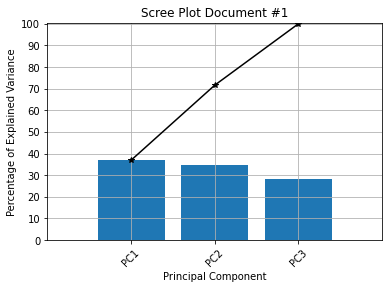

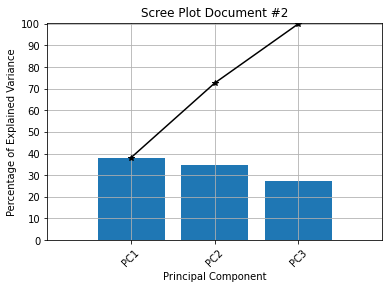

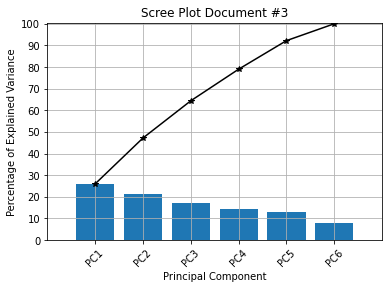

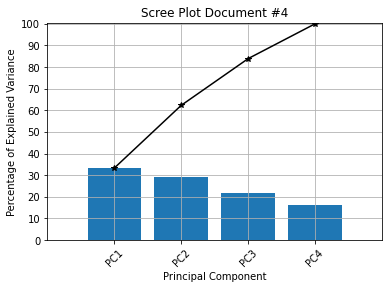

In [90]:
scree_plot_documents(DC)

The function (on='documents') works analogously to calculate_loading_scores(on='corpus') but this time prints for each document.

And get_loading_scores_documents returns a list with pandas DataFrame objects, each one with the loading scores information for a document

In [91]:
len(DC.pca_documents_list[0].components_[0])

1468

In [92]:
len(DC.pca_documents_list_WE[0].components_[0])

300

In [93]:
DC.calculate_loading_scores(on='documents')
DC.get_loading_scores(on='documents')

[                           PC_1      PC_2      PC_3  weighted_sum       sum
 (exclude, inscribe)   -0.003993  0.041557 -0.016426      0.020546  0.082522
 (assertion, meek)     -0.017280 -0.023358  0.036668      0.024892  0.102197
 (beginning, terminal)  0.021809  0.035820  0.014621      0.024625  0.096875
 (lop, secure)         -0.042692 -0.002779 -0.004302      0.017955  0.067728
 (libertine, pastor)   -0.017896 -0.030694  0.028848      0.025442  0.102880
 ...                         ...       ...       ...           ...       ...
 (doctor, patient)     -0.038334  0.011804  0.017810      0.023310  0.091258
 (god, mortal)         -0.025152 -0.030668  0.020684      0.025795  0.102298
 (china, japan)        -0.014555 -0.036160 -0.022959      0.024431  0.098104
 (fasten, loose)       -0.034678 -0.025086 -0.008144      0.023818  0.091726
 (material, spirit)     0.034806 -0.024541  0.009368      0.024024  0.092739
 
 [1468 rows x 5 columns],
                            PC_1      PC_2      

## Changing percentage of variation 

As said previously, it is possible to change the percentage of variation that is needed to reach. This way it is possible that less principal components are needed to reach the percentage of variation

In [94]:
# Set percentage pf variation to 75% (by default is 99%)
DC.set_percentage_var(0.75)

### Corpus level analysis (75% variation needed)

In [95]:
# Get the number of dimensions of the corpus with 75% of variation needed
n_dim_75 = DC.cuantify_dim(on='corpus', embedding='polar')
print(f'The corpus has a estimated complexity of: {n_dim_75} dimensions (with 75% of variation needed)')

The corpus has a estimated complexity of: 2 dimensions (with 75% of variation needed)


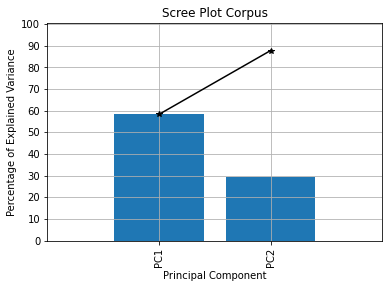

In [96]:
# Plot new scree plot for corpus (75% variation needed)
scree_plot_corpus(DC)

There are less principal components, but in those that remained the loading scores are the same 

In [97]:
# Print loading scores
DC.calculate_loading_scores(on='corpus')
DC.get_loading_scores(on='corpus').sort_values(by='PC_1', ascending=False).head()

,PC_1,PC_2,weighted_sum,sum
"(can, jar)",0.034183,-0.000594,0.020098,0.054875
"(accept, appall)",0.034181,-0.000027,0.019930,0.054139
"(actual, symbolic)",0.034178,-0.001085,0.020240,0.055503
"(acceptable, unsatisfactory)",0.034172,0.000204,0.019977,0.054353
"(guide, swat)",0.034162,0.000550,0.020073,0.054786


### Document level analysis (75% variation needed)

In [98]:
# Print dimensions estimated for each document (75% variation needed)

for i, dim in enumerate(DC.cuantify_dim(on='documents', embedding='polar')):
    print(f'Document {i+1} has a complexity of {dim} dimensions (75% variation needed)')

Document 1 has a complexity of 3 dimensions (75% variation needed)
Document 2 has a complexity of 3 dimensions (75% variation needed)
Document 3 has a complexity of 4 dimensions (75% variation needed)
Document 4 has a complexity of 3 dimensions (75% variation needed)


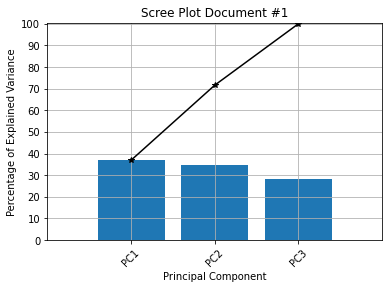

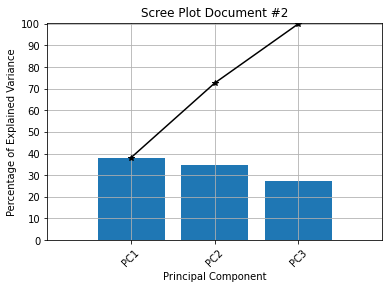

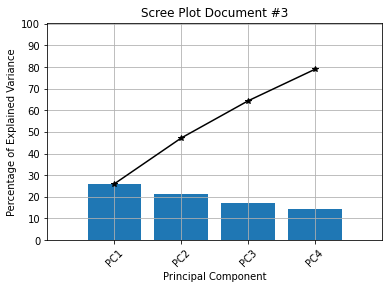

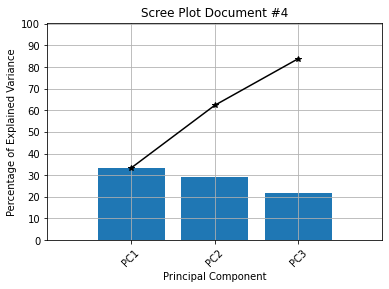

In [99]:
# Only third document changed
# New scree plots for documents (75% variation needed)

scree_plot_documents(DC)

Again, there are less principal components, but in those that remained the loading scores are the same 

In [100]:
DC.calculate_loading_scores(on='documents')
for i, df in enumerate(DC.get_loading_scores(on='documents')):
    print(f'Document {i+1}:')
    print(df.sort_values(by='PC_1', ascending=False).head())
    print()

Document 1:
                         PC_1      PC_2      PC_3  weighted_sum       sum
(automated, manual)  0.042895  0.001699 -0.001362      0.016821  0.062777
(crazy, rationale)   0.042867  0.001749  0.002191      0.017063  0.063870
(useful, waste)      0.042865  0.000963 -0.002761      0.016952  0.063540
(race, slow)         0.042853  0.001150  0.002901      0.017052  0.063956
(head, toe)          0.042757  0.002682  0.003456      0.017705  0.066600

Document 2:
                           PC_1      PC_2      PC_3  weighted_sum       sum
(bird, human)          0.042300 -0.000050  0.000809      0.016339  0.059498
(help, injure)         0.042229  0.001007 -0.002778      0.017182  0.063196
(leisure, toil)        0.042226 -0.000013 -0.003057      0.016915  0.062210
(grass, water)         0.042190 -0.002899 -0.001727      0.017532  0.064347
(engorge, streamline)  0.042165 -0.003082  0.002113      0.017692  0.065052

Document 3:
                              PC_1      PC_2      PC_3      PC

## Other functions

There are differents functions that returns useful information

In [101]:
# Obtain the polar words pairs
polar_pairs_used = DC.get_polar_pairs_list()

# Print a sample of polar pairs used
for pair in polar_pairs_used[0:5]:
    print(f'{pair[0]}, {pair[1]}')

exclude, inscribe
assertion, meek
beginning, terminal
lop, secure
libertine, pastor


In [102]:
# Obtain the last percentage of variation set

print(f'Last percentage of variation set is {DC.get_percentage_var()*100}%')

Last percentage of variation set is 75.0%


In [103]:
# Obtain pandas DataFrame of the loading scores per principal components of the corpus

DC.get_loading_scores(on='corpus').head()

,PC_1,PC_2,weighted_sum,sum
"(exclude, inscribe)",0.033721,-0.007857,0.021968,0.063546
"(assertion, meek)",-0.014366,0.041165,0.020499,0.076030
"(beginning, terminal)",-0.031545,-0.018357,0.023793,0.073696
"(lop, secure)",-0.033997,-0.001821,0.020351,0.056169
"(libertine, pastor)",-0.028926,-0.024697,0.024134,0.077756


In [104]:
# Obtain list of pandas DataFrame of the loading scores per principal components of every document

for i, df in enumerate(DC.get_loading_scores(on='documents')):
    print(f'Document {i+1}:')
    print(df.head(), end='\n\n')

Document 1:
                           PC_1      PC_2      PC_3  weighted_sum       sum
(exclude, inscribe)   -0.003993  0.041557 -0.016426      0.020546  0.082522
(assertion, meek)     -0.017280 -0.023358  0.036668      0.024892  0.102197
(beginning, terminal)  0.021809  0.035820  0.014621      0.024625  0.096875
(lop, secure)         -0.042692 -0.002779 -0.004302      0.017955  0.067728
(libertine, pastor)   -0.017896 -0.030694  0.028848      0.025442  0.102880

Document 2:
                           PC_1      PC_2      PC_3  weighted_sum       sum
(exclude, inscribe)   -0.007849  0.040518 -0.018245      0.021973  0.088584
(assertion, meek)      0.029325 -0.017674  0.029951      0.025477  0.102427
(beginning, terminal) -0.030769  0.028926  0.010827      0.024662  0.095184
(lop, secure)          0.036685  0.021055  0.007642      0.023324  0.088706
(libertine, pastor)    0.009787 -0.019588  0.043215      0.022340  0.094929

Document 3:
                           PC_1      PC_2      PC_

Obtain polar dimensions for every word in corpus

The function get_word_polar_dimensions returns a dictionary where the keys are the words in the corpus and the values are the polar embeddings vector

If cuantify_dim_documents is not previously called, it will be neccesary to call generate_word_polar_dimensions first. 

Or call generate_dimensions that calls generate_word_polar_dimensions, generate_document_polar_dimensions and generate_corpus_polar_dimensions.

In [74]:
DC.dir_matrix_transpose_inverted

array([[ 0.00905051, -0.00275327, -0.01293743, ..., -0.02188001,
         0.00011428, -0.02865988],
       [ 0.00724587, -0.01536242,  0.00327727, ..., -0.02919143,
        -0.00625131, -0.01297776],
       [-0.01788195,  0.0086614 , -0.00947651, ..., -0.0146798 ,
         0.02224425,  0.00434493],
       ...,
       [-0.01404198,  0.01409459, -0.01058266, ...,  0.0140075 ,
         0.00251218, -0.01202822],
       [ 0.00075091, -0.02986044,  0.03208043, ...,  0.00465855,
         0.03369907,  0.02709983],
       [ 0.00410626, -0.01857321, -0.00446455, ..., -0.00056391,
         0.02245015, -0.00060427]], dtype=float32)

In [75]:
# Generate word polar dimensions, not neccesary if cuantify_dim_documents or generate_dimensions were already called

DC.generate_word_polar_embeddings()

for value, count in DC.get_word_polar_embeddings().items():
    print(f'word \'{value}\' vector: {count}')

word 'i' vector: [-0.00101699  0.01070338  0.00671961 ... -0.00616216 -0.00906971
  0.00218657]
word 'like' vector: [ 0.01715218 -0.00891914  0.01231448 ... -0.0084924  -0.0141517
 -0.00578053]
word 'red' vector: [-0.00072466  0.00372744 -0.00869272 ...  0.01243144  0.00255503
 -0.00355277]
word 'candy' vector: [-0.00333598 -0.00226209  0.00393592 ...  0.00216688 -0.01340101
  0.01406644]
word 'green' vector: [-0.00092126  0.00900438 -0.00696933 ...  0.01748012 -0.0028336
 -0.00085547]
word 'is' vector: [ 0.00416609  0.00553312 -0.0115803  ... -0.00351234  0.01705728
 -0.00501589]
word 'good' vector: [ 0.00023981 -0.01085887  0.00110836 ... -0.0102926  -0.00629942
  0.00079565]
word 'and' vector: [ 0.01972004 -0.01356764  0.00799343 ... -0.00616808 -0.00577044
  0.00734454]
word 'the' vector: [ 0.00107179  0.00368371  0.0163205  ...  0.00031416  0.00547237
 -0.00312052]
word 'best' vector: [ 0.00755316 -0.0026851   0.00505244 ...  0.00473823  0.01452333
  0.01223776]
word 'bad' vector:

Obtain polar dimensions for every document in corpus

The function get_document_polar_dimensions returns a list of polar embeddings vector for each document

If cuantify_dim_corpus is not previously called, it will be neccesary to call generate_document_polar_dimensions first. 

Or call generate_dimensions that calls generate_word_polar_dimensions, generate_document_polar_dimensions and generate_corpus_polar_dimensions.

In [76]:
# Generate document polar dimensions, not neccesary if cuantify_dim_corpus or generate_dimensions were already called
DC.generate_document_polar_embeddings()

# Print a sample of document polar embeddings
for i, doc in enumerate(DC.get_document_polar_embeddings()[0:5]):
    print(f'Document {i} vector: {doc}')

Document 0 vector: [ 3.01863896e-03  8.12393603e-04  3.56932333e-03 ... -1.40590445e-05
 -8.51684848e-03  1.72992780e-03]
Document 1 vector: [ 0.00296949  0.00213163  0.00400017 ...  0.00124811 -0.00986401
  0.00240425]
Document 2 vector: [ 0.00410704 -0.00136204  0.00031967 ... -0.00047933  0.0038993
  0.00221741]
Document 3 vector: [ 0.00370536  0.00252302 -0.00124653 ... -0.00705129  0.00086458
  0.00413354]
Document 4 vector: [ 3.01863896e-03  8.12393603e-04  3.56932333e-03 ... -1.40590445e-05
 -8.51684848e-03  1.72992780e-03]


Obtain polar embeddings for the corpus

The function get_corpus_polar_dimensions returns a list of polar embeddings vector for the corpus

It is necessary to call generate_corpus_polar_dimensions first. 

Or call generate_dimensions that calls generate_word_polar_dimensions, generate_document_polar_dimensions and generate_corpus_polar_dimensions.

In [77]:
# Generate corpus polar dimensions, not neccesary if generate_dimensions was already called

DC.generate_corpus_polar_embedding()

print(f'Corpus polar dimensions vector: {DC.get_corpus_polar_embedding()}')

Corpus polar dimensions vector: [ 0.00358741  0.00064261  0.00126679 ... -0.00162642 -0.00180981
  0.00261637]


Using the polar words pairs list it is possible to match the value in the polar embeddings to each polar dimension (for word, document or corpus polar dimesions vector)

In [78]:
# Match polar pair dimension to value in polar pairs dimensions vector for the corpus

for pair, value in zip(DC.get_polar_pairs_list(), DC.get_corpus_polar_embedding()):
    print(f'polar pair: {pair[0]}, {pair[1]} | value: {value}')

polar pair: exclude, inscribe | value: 0.003587412060733707
polar pair: assertion, meek | value: 0.0006426130180713739
polar pair: beginning, terminal | value: 0.0012667937586677994
polar pair: lop, secure | value: -0.0054092313723172365
polar pair: libertine, pastor | value: 0.0005466157399695682
polar pair: hook, pocket | value: -0.0006193474777910365
polar pair: orbital, stable | value: 0.0006176678545152378
polar pair: disprove, document | value: -8.99066114915751e-06
polar pair: biological, psychological | value: -0.0023571709497345345
polar pair: preparedness, unreadiness | value: 0.004785740539699582
polar pair: dehydration, saturation | value: 0.0013406407300344037
polar pair: biologic, geologic | value: 0.007222800452764715
polar pair: accessibility, hindrance | value: -0.012401256538541437
polar pair: agree, crab | value: -0.00293743796932974
polar pair: beautify, misconstrue | value: -0.009842124738969883
polar pair: lump, separate | value: 0.011235299115947384
polar pair: d